In [319]:
#importing SARIMAX and scikit-learn packages

from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier

from pygam import GAM, s, f,LogisticGAM

In [209]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math

In [3]:
import pandas as pd
df = pd.read_csv('df.tsv', sep='\t')


/var/folders/qx/bdlxtnn15xg42mxf3d1962000000gn/T/ipykernel_45437/643515473.py:2: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df.tsv', sep='\t')


In [4]:
temp_df=df

In [5]:
#df=temp_df

In [6]:
total_incidences = pd.read_csv('total_incidences.tsv', sep='\t')

In [7]:
total_incidences.set_index('year_month', inplace=True)  # Assuming 'year_month' is the index column
numeric_series = total_incidences.squeeze()  # Convert DataFrame to Series if it has one column

# Convert to numeric, if necessary
numeric_series = pd.to_numeric(numeric_series, errors='coerce')  # Convert non-numeric to NaN (if any)

# Drop any NaN values (in case of coercion issues)
numeric_series = numeric_series.dropna()

def check_stationarity(timeseries): 
    # Perform the Dickey-Fuller test 
    result = adfuller(timeseries, autolag='AIC') 
    p_value = result[1] 
    print(f'ADF Statistic: {result[0]}') 
    print(f'p-value: {p_value}') 
    print('Stationary' if p_value < 0.05 else 'Non-Stationary') 
  
  
check_stationarity(numeric_series)

ADF Statistic: -3.2770578485854234
p-value: 0.0159356579572306
Stationary


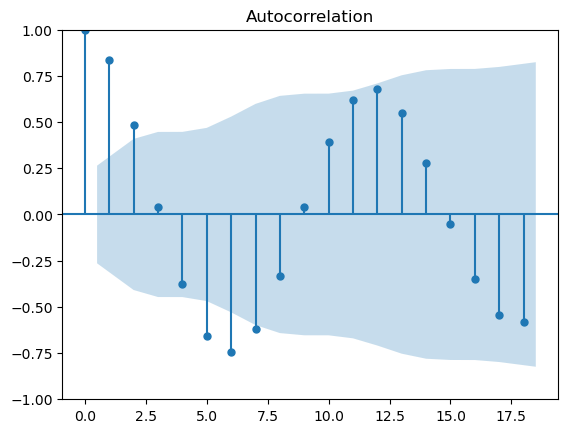

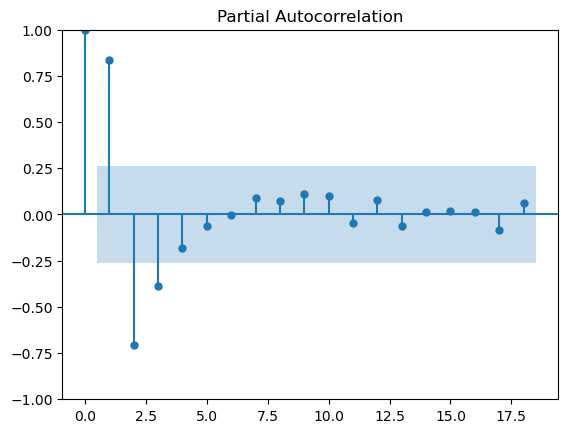

In [8]:
# Plot ACF and PACF 
plot_acf(numeric_series) 
plot_pacf(numeric_series) 
plt.show()

In [221]:
def time_prediction(parameter, offset, to_plot, title):

    p, d, q = 1, 1, 1
    P, D, Q, s = 1, 1, 1, offset  # Assuming monthly seasonality 
  
    # Fit the SARIMA model 
    model = SARIMAX(parameter, order=(p, d, q), seasonal_order=(P, D, Q, s)) 
    results = model.fit(disp=False) 

    # Forecast future values 
    forecast_periods = 12  # Forecast the next 12 months 
    forecast = results.get_forecast(steps=forecast_periods) 
    

    forecast_mean = forecast.predicted_mean 
    forecast_mean.index = forecast_mean.index.strftime('%Y-%m')
    forecast_mean.index = pd.to_datetime(forecast_mean.index)  # Convert index to datetime if necessary
    forecast_ci = forecast.conf_int() 
    forecast_ci.index = forecast_ci.index.strftime('%Y-%m')
    # Plot the forecast 
    plt.figure(figsize=(12, 6)) 
    #numeric_series = numeric_series.astype(float)  # Ensure data types are compatible
    
    #numeric_series.index = pd.to_datetime(numeric_series.index)
    
    to_plot.plot(label='Observed') 
    forecast_mean.plot(label='Forecast', color='red') 
    plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink') 
    plt.title(title) 
    plt.xlabel("Time") 
    plt.ylabel("Number of rides") 
    plt.legend() 
    plt.show()
    
    return forecast_mean 

/Users/victor/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/victor/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/victor/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


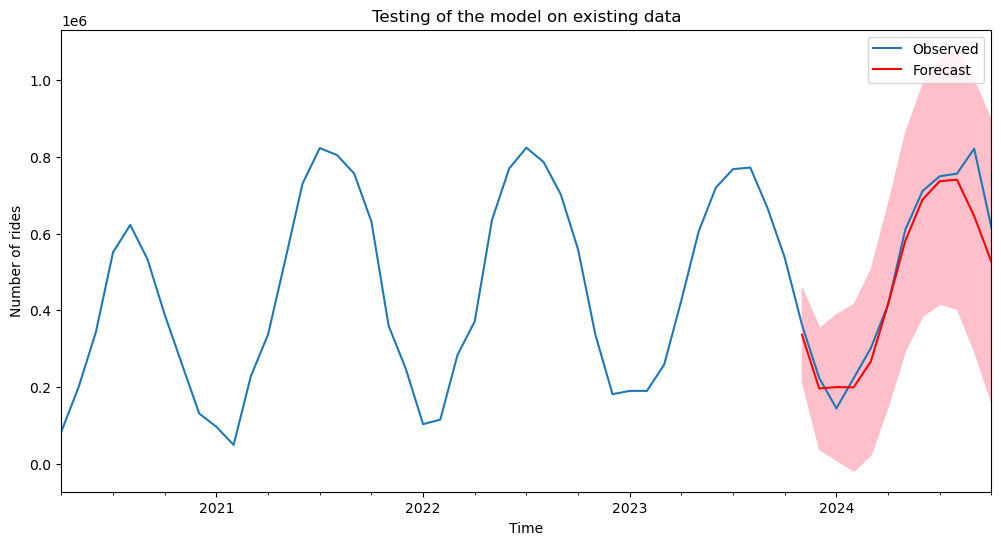

MAE: 42854.23806631796
RMSE: 62538.64858351986
R2: 0.927159975636868


In [351]:
numeric_series = numeric_series.astype(float)  # Ensure data types are compatible
numeric_series.index = pd.to_datetime(numeric_series.index)

forecast_cut_sarima = time_prediction(numeric_series[:-12],12, numeric_series, "Testing of the model on existing data")
#forecast_mean = time_prediction(numeric_series, len(numeric_series), numeric_series, "Testing of the model on existing data")

observed = numeric_series[-12:]
#observed = numeric_series
mae = mean_absolute_error(observed, forecast_mean) 
mse = mean_squared_error(observed, forecast_mean) 
r2 = r2_score(observed, forecast_mean)
print(f'MAE: {mae}') 
print(f'RMSE: {math.sqrt(mse)}')
print(f'R2: {r2}')

/Users/victor/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/victor/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/victor/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


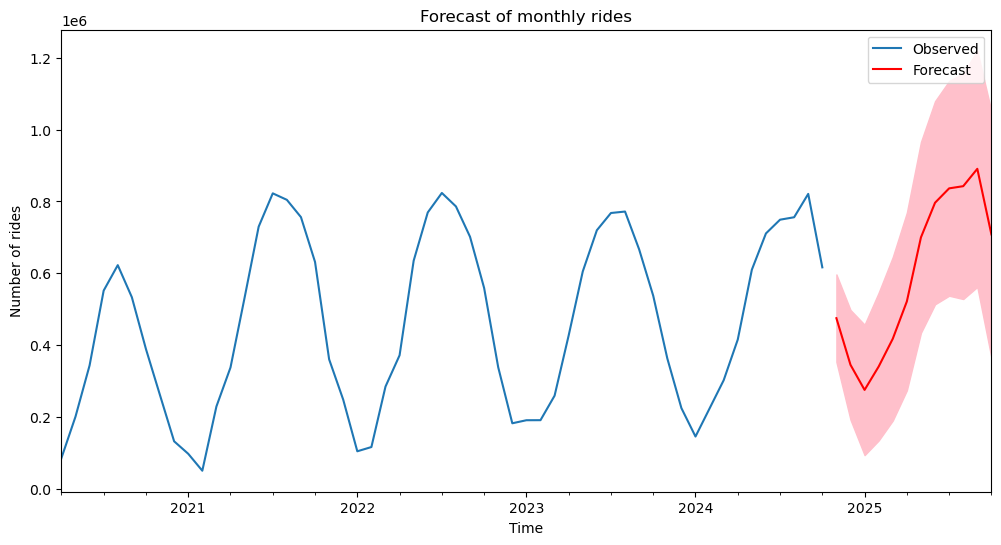

In [352]:
forecast_full_sarima = time_prediction(numeric_series, 12, numeric_series, "Forecast of monthly rides")

In [12]:
df['year'] = pd.to_datetime(df['started_at']).dt.year
df['month'] = pd.to_datetime(df['started_at']).dt.month
df['season'] = (df['month']-1)//3
df['rideable_type'] = df['rideable_type'].replace({'classic_bike': 1, 'electric_bike': 2, 'docked_bike': 3, 'electric_scooter': 4})
df['rideable_type'] = df['rideable_type'].astype(int)

In [52]:
df_xgboost = df[df.ride_time_minutes > 0].groupby(['year_month','rideable_type']).agg(
    ride_id_count=('ride_id', 'count'),  # Count of 'ride_id'    
    year = ('year','max'),
    month = ('month','max'),
    season = ('season','max')
).reset_index()

In [324]:
def split_tables(df):
    
    df['ride_id_count_2month_ago'] = df['ride_id_count'].shift(2)
    df['ride_id_count_lastmonth'] = df['ride_id_count'].shift(1)
    df = df.iloc[2:]
    return df

In [325]:
df1 = split_tables(df_xgboost[df_xgboost.rideable_type == 1])
df2 = split_tables(df_xgboost[df_xgboost.rideable_type == 2])

/var/folders/qx/bdlxtnn15xg42mxf3d1962000000gn/T/ipykernel_45437/1983575650.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ride_id_count_2month_ago'] = df['ride_id_count'].shift(2)
/var/folders/qx/bdlxtnn15xg42mxf3d1962000000gn/T/ipykernel_45437/1983575650.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ride_id_count_lastmonth'] = df['ride_id_count'].shift(1)
/var/folders/qx/bdlxtnn15xg42mxf3d1962000000gn/T/ipykernel_45437/1983575650.py:3: SettingWithCopyWarning: 
A value is trying to be se

In [64]:
df_full = pd.concat([df1, df2], ignore_index=True)

In [65]:
df_full = df_full.sort_values(by='year_month').reset_index(drop=True)

In [68]:
y = df_full['ride_id_count']
X = df_full.drop(columns=['year_month','ride_id_count'], axis=1)

In [69]:
my_model_1 = XGBRegressor(random_state=0, max_depth=3, n_estimators=100, learning_rate=0.3, objective='count:poisson') 

kfold = KFold(n_splits=5)
results_1 = cross_val_score(my_model_1, X, y, cv=kfold, error_score='raise')

print("Accuracy %.2f%% with a standard deviation %.2f%%" % (results_1.mean()*100, results_1.std()*100))

Accuracy 89.49% with a standard deviation 5.39%


In [70]:
from sklearn.metrics import mean_absolute_error, r2_score

In [333]:
def fit_model_xgboost(df):

    y = df['ride_id_count']
    X = df.drop(columns=['year_month','ride_id_count'], axis=1)
    #train_size = int(len(df) * 0.8)  # Calculate the index to split at
    #X_train, X_valid = X[-train_size:], X[:-train_size]  # First 80% for training, last 20% for validation
    #y_train, y_valid = y[-train_size:], y[:-train_size]  # Split the target variable similarly
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=1) 
    param_grid = {'max_depth':[3, 4, 5],  
                  'n_estimators':[50, 100, 200, 300], 
                  'learning_rate':[0.005, 0.01, 0.05, 0.1, 0.3, 0.5],
                  }  
    
    grid = GridSearchCV(XGBRegressor(random_state=1, objective='count:poisson'), param_grid, refit = True, n_jobs=-1) 
    grid.fit(X_train, y_train)
    print(grid.best_params_) 
    grid_pred = grid.predict(X_valid)
    print("Mean absolute error: %s" % mean_absolute_error(y_valid, grid_pred))
    print("RMSE: %s" % math.sqrt(mean_squared_error(y_valid, grid_pred)))
    print("R2 score: %s" % r2_score(y_valid, grid_pred))
    return grid

In [334]:
def fit_GAM(df):

    y = df['ride_id_count']
    X = df.drop(columns=['year_month','ride_id_count'], axis=1)
    model = GAM().fit(X,y)
    return model

In [335]:
fulldata_xgboost = fit_model_xgboost(df_full)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Mean absolute error: 28993.416118421053
RMSE: 32652.50345232233
R2 score: 0.9279938685216053


In [336]:
cutdata_xgboost = fit_model_xgboost(df_full[:-24])

{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100}
Mean absolute error: 28853.311458333334
RMSE: 37116.197629707545
R2 score: 0.9187578732422566


In [337]:
fulldata_GAM = fit_GAM(df_full)

In [338]:
cutdata_GAM = fit_GAM(df_full[:-24])

In [339]:
def make_prediction(df,grid):
        
    df = df.reset_index(drop=True)
    last_2row = df.iloc[-2]
    last_row = df.iloc[-1]
    # Initialize the new DataFrame for predictions
    forecast_data = []
    
    # Extract initial values
    
    
        # Generate predictions for the next 12 months
        
    current_month = last_row['month']+1
        
    if current_month%3 == 1:
        current_season = last_row['season']+1
    else:
        current_season = last_row['season']
        
    if  current_month > 12:  # Increment the year if the month exceeds 12
        current_month = 1
        current_year = last_row['year']+1
        current_season = 0
    else:
        current_year = last_row['year']
    
    current_ride_id_count = last_2row['ride_id_count']  # Use as starting value for ride_id_count_lastmonth
    current_ride_id_count_plusmonth = last_row['ride_id_count']
    for _ in range(12):
        # Prepare the input features for prediction
        input_features = pd.DataFrame({
            'rideable_type' : [df['rideable_type'][0]],
            'year': [current_year],
            'month': [current_month],
            'season' : [current_season],
            'ride_id_count_2month_ago': [current_ride_id_count],
            'ride_id_count_lastmonth' : [current_ride_id_count_plusmonth]
        })
    
        # Predict the ride_id_count for the current month
        predicted_ride_id_count = grid.predict(input_features)[0]  # Extract the prediction value
    
        # Append the forecasted data
        forecast_data.append({
            'rideable_type' : df['rideable_type'][0],
            'year': current_year,
            'month': current_month,
            'season': current_season,
            'ride_id_count_2month_ago': current_ride_id_count,
            'ride_id_count_lastmonth': current_ride_id_count_plusmonth,
            'ride_id_count': predicted_ride_id_count
        })
    
        # Update the values for the next iteration
        #rideable_type = 1 if rideable_type == 2 else 2
        current_ride_id_count = current_ride_id_count_plusmonth
        current_ride_id_count_plusmonth = predicted_ride_id_count  # Use the current prediction for the next month's lastmonth value
        
        current_month += 1
        
        if current_month%3 == 1:
            current_season += 1
        
        if current_month > 12:  # Increment the year if the month exceeds 12
            current_month = 1
            current_year += 1
            current_season = 0

    # Create a DataFrame from the forecasted data
    forecast_df = pd.DataFrame(forecast_data)

    # Display the result
    
    return forecast_df

In [340]:
forecast_full_1_xgboost = make_prediction(df_full[df_full.rideable_type == 1],fulldata_xgboost)
forecast_full_2_xgboost = make_prediction(df_full[df_full.rideable_type == 2],fulldata_xgboost)

In [341]:
forecast_cut_1_xgboost = make_prediction(df_full[df_full.rideable_type == 1][:-12],cutdata_xgboost)
forecast_cut_2_xgboost = make_prediction(df_full[df_full.rideable_type == 2][:-12],cutdata_xgboost)

In [342]:
forecast_full_1_GAM = make_prediction(df_full[df_full.rideable_type == 1],fulldata_GAM)
forecast_full_2_GAM = make_prediction(df_full[df_full.rideable_type == 2],fulldata_GAM)

In [343]:
forecast_cut_1_GAM = make_prediction(df_full[df_full.rideable_type == 1][:-12], cutdata_GAM)
forecast_cut_2_GAM = make_prediction(df_full[df_full.rideable_type == 2][:-12], cutdata_GAM)

In [ ]:
numeric_series.index = numeric_series.index.strftime('%Y-%m')
forecast_full_sarima.index = forecast_full_sarima.index.strftime('%Y-%m')
forecast_cut_sarima.index = forecast_cut_sarima.index.strftime('%Y-%m')

In [367]:
def make_time_column(forecast):
    forecast['time'] = forecast['year'].astype(int).astype(str) + '-' + forecast['month'].astype(int).astype(str).str.zfill(2)

In [368]:
def merge_columns(forecast_classic,forecast_electric):

    make_time_column(forecast_classic)
    make_time_column(forecast_electric)

    forecast_full = pd.DataFrame()

    # Iterate through columns
    for col in forecast_classic.columns:
        if col in ['ride_id_count','ride_id_count_lastmonth','ride_id_count_2month_ago']:
        # Sum numeric columns
            
            forecast_full[col] = forecast_classic[col] + forecast_electric[col]
        else:
        
            forecast_full[col] = forecast_classic[col]
    
    return forecast_full

In [369]:
def plot_aggr_predictions(forecast_sarima, forecast_classic, forecast_electric, forecast_classic_GAM, forecast_electric_GAM, filename):

    forecast_merged_xgboost = merge_columns(forecast_classic,forecast_electric)
    forecast_merged_GAM = merge_columns(forecast_classic_GAM,forecast_electric_GAM)
    
    plt.figure(figsize=(12, 6)) 

    year_ticks = [label for label in numeric_series.index if '-01' in label] + ['2025-01']
    # Plot the total incidences
    plt.figure(figsize=(10, 6))
    plt.plot(numeric_series.index, numeric_series.values, marker='o', linestyle='-', label='Data')
    plt.plot(forecast_merged_xgboost['time'], forecast_merged_xgboost['ride_id_count'], color='black', marker='o', linestyle='-', label='XGBoost forecast')
    plt.plot(forecast_sarima.index, forecast_sarima.values, color = 'red', marker='o', linestyle='-', label='SARIMA forecast')
    plt.plot(forecast_merged_GAM['time'], forecast_merged_GAM['ride_id_count'], color='magenta', marker='o', linestyle='-', label='GAM')

    plt.title("Data and forecasts") 
    plt.xticks(year_ticks)
    plt.xlabel("Time") 
    plt.ylabel("Number of rides") 
    plt.legend()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(filename+'.png',dpi=100)

<Figure size 1200x600 with 0 Axes>

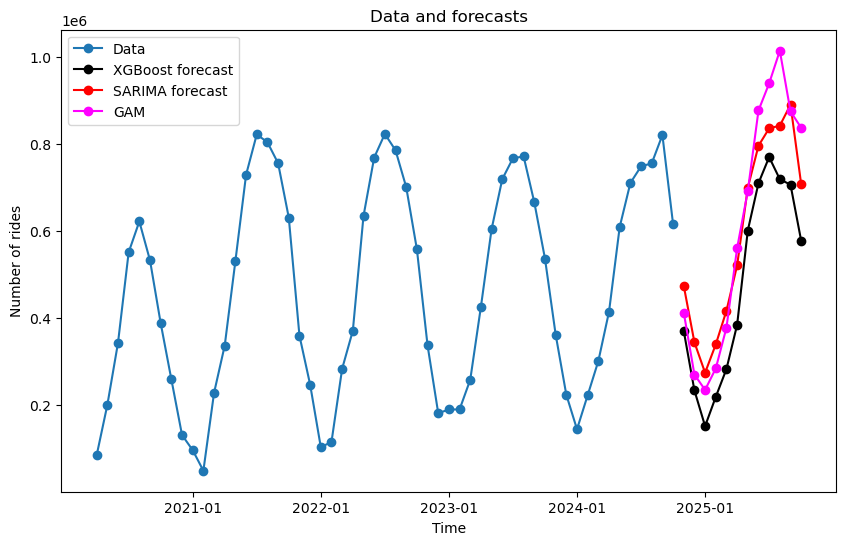

<Figure size 640x480 with 0 Axes>

In [372]:
plot_aggr_predictions(forecast_full_sarima,forecast_full_1_xgboost,forecast_full_2_xgboost,forecast_full_1_GAM,forecast_full_2_GAM,'new_full_10dec')

<Figure size 1200x600 with 0 Axes>

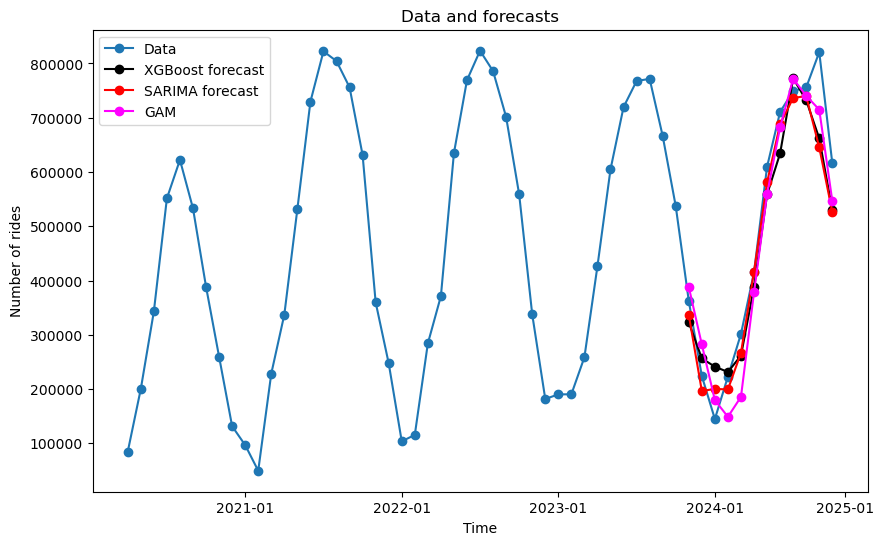

<Figure size 640x480 with 0 Axes>

In [373]:
plot_aggr_predictions(forecast_cut_sarima,forecast_cut_1_xgboost,forecast_cut_2_xgboost,forecast_cut_1_GAM,forecast_cut_2_GAM,'new_cut_10dec')

In [374]:
metrics = pd.DataFrame({
        'month': forecast_cut_sarima.index,
        'absolute error, SARIMA': abs((forecast_cut_sarima - numeric_series.values[-12:]).astype(int)).values,
        'relative error, SARIMA': abs((forecast_cut_sarima - numeric_series.values[-12:]).astype(int)).values/numeric_series.values[-12:],
        'absolute error, XGBoost': abs(((forecast_cut_1 + forecast_cut_2)['ride_id_count'] - numeric_series.values[-12:]).astype(int)).values,
        'relative error, XGBoost': abs(((forecast_cut_1 + forecast_cut_2)['ride_id_count'] - numeric_series.values[-12:]).astype(int)).values/numeric_series.values[-12:],
        'absolute error, GAM': abs(((forecast_cut_1_GAM + forecast_cut_2_GAM)['ride_id_count'] - numeric_series.values[-12:]).astype(int)).values,
        'relative error, GAM': abs(((forecast_cut_1_GAM + forecast_cut_2_GAM)['ride_id_count'] - numeric_series.values[-12:]).astype(int)).values/numeric_series.values[-12:]
         
    })


In [375]:
metrics

,month,"absolute error, SARIMA","relative error, SARIMA","absolute error, XGBoost","relative error, XGBoost","absolute error, GAM","relative error, GAM"
0,2023-11,25820,0.071224,33354,0.092006,25618,0.070667
1,2023-12,27528,0.122853,17445,0.077854,58128,0.259415
2,2024-01,55452,0.382763,39557,0.273046,34769,0.239996
3,2024-02,23721,0.106294,36237,0.162378,74241,0.332675
4,2024-03,34776,0.115272,40031,0.132691,115926,0.384259
5,2024-04,1598,0.003850,101565,0.244720,36792,0.088650
6,2024-05,29017,0.047592,171823,0.281814,50597,0.082986
7,2024-06,22424,0.031550,176417,0.248213,28254,0.039753
8,2024-07,12714,0.016975,79466,0.106096,22912,0.030590
9,2024-08,15748,0.020836,72367,0.095748,15311,0.020258


In [377]:
print("GAM accuracy")
print("------------")
print("Mean absolute error: %s" % mean_absolute_error(numeric_series.values[-12:], (forecast_cut_1_GAM + forecast_cut_2_GAM)['ride_id_count']))
print("RMSE: %s" % math.sqrt(mean_squared_error(numeric_series.values[-12:], (forecast_cut_1_GAM + forecast_cut_2_GAM)['ride_id_count'])))
print("R2 score: %s" % r2_score(numeric_series.values[-12:], (forecast_cut_1_GAM + forecast_cut_2_GAM)['ride_id_count']))

GAM accuracy
------------
Mean absolute error: 53171.21012440582
RMSE: 61731.55475212069
R2 score: 0.9290279208530778
